<a href="https://colab.research.google.com/github/samarthaFFM/project1/blob/master/RNA_seq_workshop_ASHG19_PRISMES_FAM001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>RNA-seq workshop @ ASHG 2019</h1>

A hands-on rare disease diagnostic workshop on RNA-seq data @ ASHG19

The accompanying presentation can be found here: [tinyurl.com/RNA-ASHG-presentation](https://tinyurl.com/RNA-ASHG-presentation).

And if any troubles arise please refer to the FAQ [here](https://tinyurl.com/RNA-ASHG-FAQ).

---

# Setup the notebook

To get started we have to setup this IR notebook @ Colab. To do so please run the following code snippet.
This will download all necessary software packages for this tutorial. Also, it will download the example datasets used throughout this tutorial.

In [ ]:
download.file(destfile="r-env-setup-script.R", 
    url="https://raw.githubusercontent.com/c-mertes/RNAseq-ASHG19/master/r-env-setup-script.R")
source("r-env-setup-script.R")
print("Setup done")

Update and install needed Ubuntu packages

Download R package cache

Unzipping R package cache

Retrieve data for tutorials



[1] "Setup done"


To finalize the setup reset the runtime by clicking:

```
Runtime > Restart runtime > Yes.
```

Now you are ready for the workshop. Let's get started!


# Expression Outlier Detection in RNA-seq data

A short introduction to expression outlier detection can be found [here](https://docs.google.com/presentation/d/1a7KZ6FXwVmGqF-FMAnz0QTk07WgzRWAbFhSNrUBspIQ/edit#slide=id.g630401e960_5_0).





## Data import
---

First we have to load the [*OUTRIDER*](http://bioconductor.org/packages/release/bioc/html/OUTRIDER.html) package that we will use to run the full expression outlier analysis. To map ENSEMBL gene names and HGNC symbols we use [*annotables*](https://github.com/stephenturner/annotables). For efficient data handling and visualization we further load [*data.table*](https://cran.r-project.org/web/packages/data.table/index.html), [*ggplot2*](https://cran.r-project.org/web/packages/ggplot2/index.html), and [*ggpubr*](https://cran.r-project.org/web/packages/ggpubr/index.html).

In [ ]:
library(OUTRIDER)
library(annotables)
library(data.table)
library(ggplot2)
library(ggpubr)

For the gene expression outlier detection analysis, we need the raw read counts and a sample annotation. Let's load them into the session.

Have a look at the annotations we use and how many genes were counted.

In [ ]:
# sample annotation and raw read counts
anno <- fread("./annotation.tsv")[, 1:6]
cts  <- as.matrix(read.table("./outrider/raw_counts.tsv.gz"))

# look into the data
head(anno)
print("Dimensions of the annotation:")
dim(anno)

cts[1:5, 1:10]
print("Dimensions of the count table:")
dim(cts)

RNA_ID,SEX,ORIGIN,LAB,INDIVIDUAL,phase1TG
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
HG00096.1.M_111124_6,male,British,UNIGE,HG00096,1
HG00103.4.M_120208_3,male,British,ICMB,HG00103,1
HG00106.4.M_120208_5,female,British,ICMB,HG00106,1
HG00111.2.M_111215_4,female,British,CNAG_CRG,HG00111,1
HG00116.2.M_120131_1,male,British,CNAG_CRG,HG00116,1
HG00126.1.M_111124_8,male,British,UNIGE,HG00126,1


[1] "Dimensions of the annotation:"


[1] 100   6

,HG00096,HG00103,HG00106,HG00111,HG00116,HG00126,HG00132,HG00149,HG00150,HG00176
ENSG00000000003.14_2,1,3,1,15,1,5,0,3,5,0
ENSG00000000005.5_2,0,0,0,0,0,0,0,0,0,0
ENSG00000000419.12_2,853,1131,1148,1341,863,948,1363,671,1452,1070
ENSG00000000457.13_3,413,438,510,482,385,583,547,442,504,337
ENSG00000000460.16_5,338,262,470,547,472,503,725,514,596,320


[1] "Dimensions of the count table:"


[1] 60829   100

We can see that we have ~60,000 genes and 100 samples in our experiment. For counting, we used all the genes annotated in the [GENCODE v29 annotation](https://www.gencodegenes.org/human/release_29lift37.html).

Create an *OUTRIDER* object with the loaded annotation and raw count matrix by running `OutriderDataSet`.

In [ ]:
anno[,sampleID:=INDIVIDUAL]
ods <- OutriderDataSet(countData=cts, colData=anno)
ods

class: OutriderDataSet
class: RangedSummarizedExperiment 
dim: 60829 100 
metadata(1): version
assays(1): counts
rownames(60829): ENSG00000000003.14_2 ENSG00000000005.5_2 ...
  ENSG00000285993.1_1 ENSG00000285994.1_1
rowData names(0):
colnames(100): HG00096 HG00103 ... NA20805 NA20811
colData names(7): RNA_ID SEX ... phase1TG sampleID

## Quality control and preprocessing of raw count data

In this tutorial only a few quality control metrics are explored. In a real experiment setup, this step should be done more extensively ([see slides for hints](https://docs.google.com/presentation/d/1a7KZ6FXwVmGqF-FMAnz0QTk07WgzRWAbFhSNrUBspIQ/edit?pli=1#slide=id.g64b01c344e_4_51)). 

### Size factor

One important metric is the *sizeFactor*. The *sizeFactor* represents the sequencing depth of each sample with respect to the others and is centered around 1. The *sizeFactor* can be estimated with `estimateSizeFactors` based on the [*DESeq2*](http://bioconductor.org/packages/release/bioc/html/DESeq2.html) function. In gene expression analysis one of the first normalization steps is done using the *sizeFactor*.

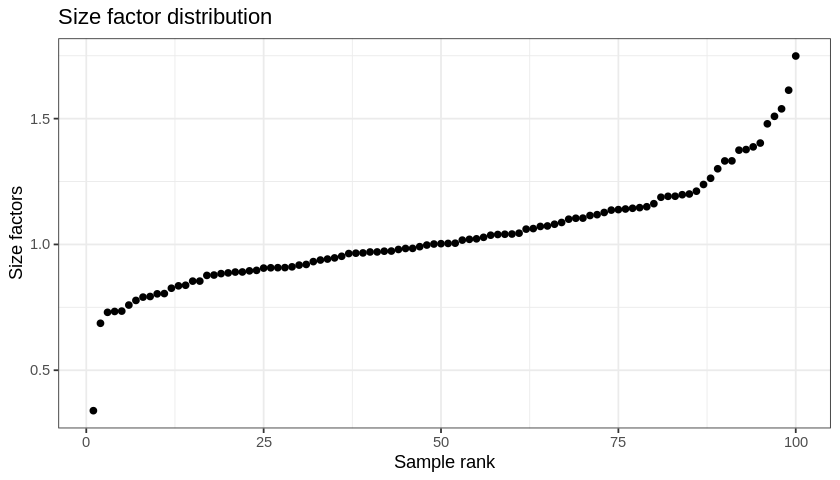

In [ ]:
# estimate sizeFactors 
ods <- estimateSizeFactors(ods)

# plot the sizeFactor across the dataset
ggplot(data=NULL, aes(y=sort(sizeFactors(ods)), x=1:ncol(ods))) + 
    geom_point() + 
    labs(x='Sample rank', y='Size factors', title="Size factor distribution") + 
    theme_bw()

As expected, most data points are around 1. A low *sizeFactor* could be an indication for a failed experiment or other issues during the preparation (eg. low RNA input). Those samples should be dealt with caution. Also high *sizeFactors* should be investigated. 

Let's have a look at the sample with the lowest *sizeFactor*. 

In [ ]:
sort(sizeFactors(ods))[1:5]

NA20778   NA20805   NA06984   NA20540   HG00278 
0.3393214 0.6866933 0.7302284 0.7336435 0.7350451

### Filter non-expressed genes

Not all genes are expressed in a given tissue/sample. It depends on the tissues and sequencing depth on how many expressed genes are expected. 

To make the modeling and outlier detection more robust, a good filtering of non-expressed genes is crucial. The cutoffs are dependent on the project and should be defined beforehand. The FPKM value (fragments per kilobase of million mapped reads) is a good measurement for this.

Here, we keep genes where at least 5% of the samples have an FPKM value greater than 1.

To compute the FPKM value, we need the gene length from the annotation file. 

In [ ]:
# load gene annotation to compute FPKM values
txdb <- loadDb("annotations/gencode.v29lift37.annotation.txdb")
ods <- filterExpression(ods, gtfFile=txdb, filterGenes=FALSE)

45212 genes did not pass the filter. This is 74.3% of the genes.



Plot the number of genes filtered out and their expression distribution across all sample/gene pairs.

3504263 sample-gene combinations are zero. This is 57.6% of the data



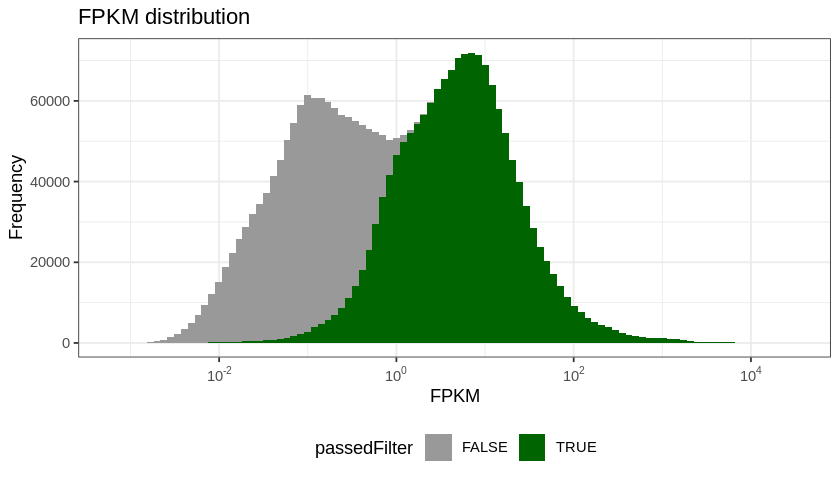

In [ ]:
# FPKM distribution across all sample/gene pairs
plotFPKM(ods) + theme_bw() + theme(legend.position = 'bottom')

Let's subset now the object for expressed genes only. Have a look at the output on how many genes/samples (below as `dim`) we ended up for the final analysis.

In [ ]:
# filter object based on the expression status of the genes
ods <- ods[mcols(ods)[,"passedFilter"]]
ods

class: OutriderDataSet
class: RangedSummarizedExperiment 
dim: 15617 100 
metadata(1): version
assays(1): counts
rownames(15617): ENSG00000000419.12_2 ENSG00000000457.13_3 ...
  ENSG00000285976.1_1 ENSG00000285979.1_1
rowData names(3): loggeomeans passedFilter basepairs
colnames(100): HG00096 HG00103 ... NA20805 NA20811
colData names(13): sampleID RNA_ID ... passedFilterGenes
  expressedGenesRank

### Sample co-variation
Usually in RNA-seq data one can see sample co-variation and hence should control for that. In most of the cases one knows the cause of the structure (eg. sex, origin, batch) but sometimes it comes from unkown confounders. For more details [see slides](https://docs.google.com/presentation/d/1a7KZ6FXwVmGqF-FMAnz0QTk07WgzRWAbFhSNrUBspIQ/edit#slide=id.g614aa1ac41_0_33).

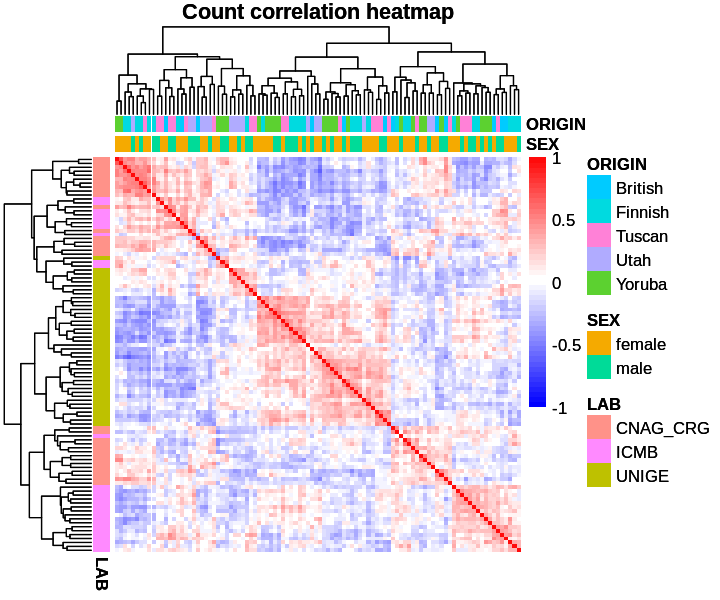

In [ ]:
# Make heatmap figure bigger
options(repr.plot.width=6, repr.plot.height=5)

# use normalize=FALSE since the data is not yet corrected
plotCountCorHeatmap(ods, colGroups=c("SEX", "ORIGIN"), rowGroups="LAB",
        normalize=FALSE)

## Detection of expression outlier events

We have loaded the data, did some quality control, and preprocessed (filtered) the data. Now we can start with the **normalization** and **outlier detection**.


<img src="https://github.com/gagneurlab/OUTRIDER/raw/master/vignettes/autoencoder_sketch.png" alt="Using a denoising autoencoder to correct for sample co-variations." width="400"/>

### Fitting the model

We will now use *OUTRIDER* to model the sample co-variation, also called latent space, based on the given gene expression data. Here we use a predefined latent space with a dimension $q=15$. Using the correct dimension is crucial to have the best performance. Finding the right dimension can be done with `findEncodingDim()`.

In [ ]:
ods <- OUTRIDER(ods, q=15, verbose=TRUE, 
        iterations=2, # only used here 2 iterations to speed up the tutorial
        BPPARAM=MulticoreParam(4, progressbar=TRUE))  # Takes around 2min

Wed Jun 24 16:44:17 2020: SizeFactor estimation ...

Wed Jun 24 16:44:18 2020: Controlling for confounders ...

Wed Jun 24 16:44:18 2020: Using the autoencoder implementation for controlling.



[1] "Wed Jun 24 16:44:23 2020: Initial PCA loss: 5.81400644768784"
  |======================================================================| 100%


CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH 
                                          15617 
[1] "Wed Jun 24 16:44:44 2020: Iteration: init D loss: 5.79646828714987"
  |======================================================================| 100%

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.0617   26.9323   77.9328  118.9740  156.5255  999.9999 
[1] "Wed Jun 24 16:44:54 2020: Iteration: init Theta loss: 5.31569050462055"
[1] "Wed Jun 24 16:45:11 2020: Iteration: 1 E loss: 5.28225151892558"
  |======================================================================| 100%


CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH 
                                          15617 
[1] "Wed Jun 24 16:45:25 2020: Iteration: 1 D loss: 5.27338827364138"
  |======================================================================| 100%


Wed Jun 24 16:46:09 2020: Used the autoencoder implementation for controlling.

Wed Jun 24 16:46:09 2020: P-value calculation ...



  |======================================================================| 100%



Wed Jun 24 16:46:15 2020: Zscore calculation ...



Let's see how well the denoising autoencoder fitted the latent space of our data. Ideally, we should not see any clusters anymore and most of the plot should be rather white than red or blue except for the diagonal.

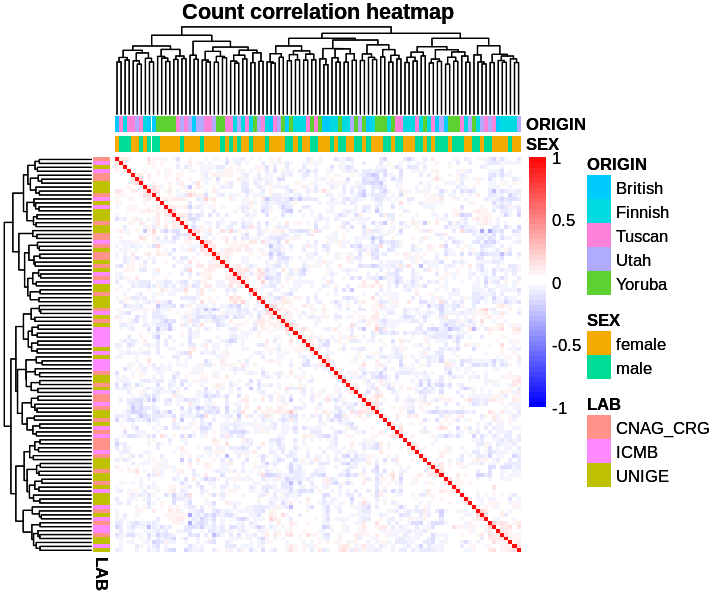

In [ ]:
plotCountCorHeatmap(ods, colGroups=c("SEX", "ORIGIN"), rowGroups="LAB",
        normalize=TRUE)

### Detection of expression outliers

After fitting the model and correcting for sample co-variations, we can now obtain our expression outliers. 
Here, we define an outlier as an event that significantly deviates from the expected Negative-Binomial distribution after controlling for confounders. For details [see slides](https://docs.google.com/presentation/d/1a7KZ6FXwVmGqF-FMAnz0QTk07WgzRWAbFhSNrUBspIQ/edit#slide=id.g64b01c344e_4_158).

<img src="https://github.com/c-mertes/RNAseq-ASHG19/raw/master/src/nb-p-value.PNG" alt="no image" width="250"/>

The two sided p value is defined as:

$ P(k_{ij}) = 2 \cdot \min\left( \frac{1}{2}, \sum_{k=0}^{k_{ij}} NB(k_{ij}|\mu_{ij}), \theta_j), 1-\sum_{k=0}^{k_{ij}} NB(k_{ij}|\mu_{ij},\theta_j) \right)$,

with a genome-wide significance threshold of $FDR < 0.05$.

Let's check how many expression outliers per sample were found.


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 32 rows containing missing values (geom_bar).”


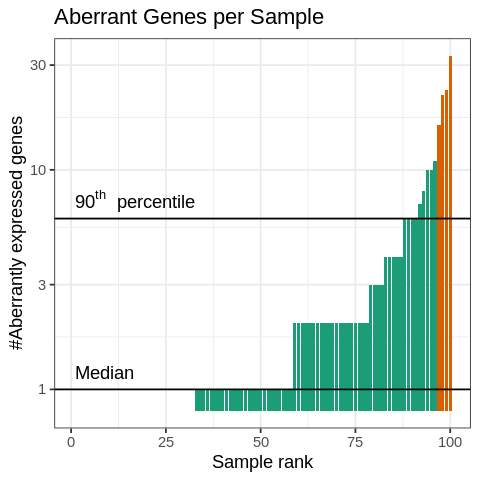

In [ ]:
# make the plot again default size
options(repr.plot.width=4, repr.plot.height=4)

plotAberrantPerSample(ods)

### Z score approach

There are many different ways to define outliers. One common approach is to compute a Z score and then define outliers as $|z| > 3$ or $|z| > 2$. In our [OUTRIDER publication](https://doi.org/10.1016/j.ajhg.2018.10.025), we recommend to use a statistical assesment for defining outliers over the Z score approach.

Despite our recommendation, one can use OUTRIDER to retrieve Z score derived outliers by setting `padjCutoff=1` and `zScoreCutoff=2` or another value of choice.

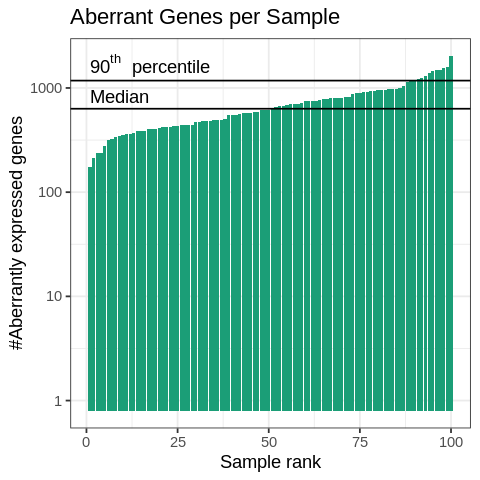

In [ ]:
plotAberrantPerSample(ods, padjCutoff=1, zScoreCutoff=2, yadjust=c(1.3,1.4))

In order to make the results table more intuitive, we now change the ENSEMBL gene IDs into HGNC symbols. For this we use the *annotables* package.

In [ ]:
# remove versioning of gene IDs and merge with GRCh37 from annotables
geneIDs <- gsub("\\.[0-9]*(_[0-9]*)?.*$", "", rownames(ods))
map <- merge(data.table(ensgene=geneIDs), grch37, sort=FALSE,
        all.x=TRUE)[!duplicated(ensgene),]

# set new gene names only if hgnc symbol is present
if(!"ENSG" %in% colnames(mcols(ods))){
    mcols(ods)$ENSG <- geneIDs
    rownames(ods) <- map[,ifelse(
            is.na(symbol) | symbol == "" | duplicated(symbol), geneIDs, symbol)]
}

Now we can retrieve our expression outliers using the *results* function.

In [ ]:
res <- results(ods)
head(res)
dim(res)

geneID,sampleID,pValue,padjust,zScore,l2fc,rawcounts,normcounts,meanCorrected,theta,aberrant,AberrantBySample,AberrantByGene,padj_rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
ZNF549,NA12341,2.794264e-20,4.465636e-15,-9.36,-4.90,4,5.46,202.81,32.67,TRUE,11,1,1
CAT,NA18873,1.277582e-17,2.041760e-12,-9.18,-5.49,24,26.68,1242.71,14.33,TRUE,4,1,1
FAM127A,NA06984,2.171443e-16,3.470280e-11,-8.73,-2.80,65,61.87,436.61,37.30,TRUE,33,1,1
TXN2,HG00103,9.124427e-16,1.458215e-10,-8.38,-1.48,852,974.13,2712.67,89.84,TRUE,10,1,1
PARP4,NA18916,4.215504e-14,6.736984e-09,-8.16,-2.21,833,572.89,2648.97,39.61,TRUE,7,1,1
PKP4,NA12717,1.351949e-13,2.160610e-08,-8.55,-4.80,6,24.30,774.88,15.92,TRUE,23,1,1


[1] 262  14

## Finding candidates in a patient

We know that patient **NA18873** has a rare mitochondrial disease with a complex I deficiency. This means that we are looking for mitochondrial or complex I related genes.

Let's have a look at the patient's volcano plot. This shows the effect of the event on the x axis (Z score) and the significance on the y axis (nominal p value).

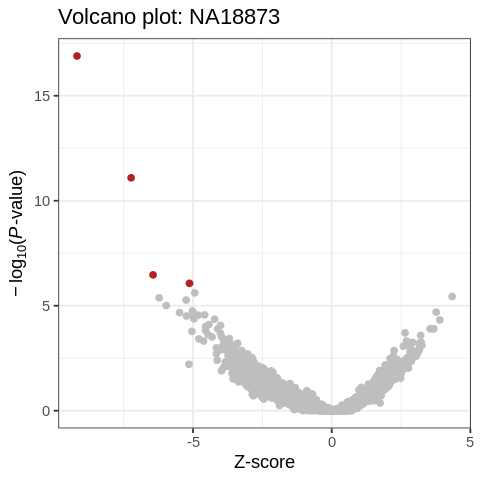

In [ ]:
# volcano plot of sample NA18873
plotVolcano(ods, "NA18873", base=TRUE)

And further have a closer look at the outliers of this case in detail.

In [ ]:
# subset results for this patient
res[sampleID == "NA18873"]

geneID,sampleID,pValue,padjust,zScore,l2fc,rawcounts,normcounts,meanCorrected,theta,aberrant,AberrantBySample,AberrantByGene,padj_rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
CAT,NA18873,1.277582e-17,2.041760e-12,-9.18,-5.49,24,26.68,1242.71,14.33,TRUE,4,1,1
TIMMDC1,NA18873,8.101708e-12,6.473849e-07,-7.23,-1.06,341,486.98,1010.41,139.09,TRUE,4,1,2
RP11-325F22.2,NA18873,3.393334e-07,1.807679e-02,-6.44,-4.97,0,0.00,42.16,12.87,TRUE,4,1,3
DCTD,NA18873,8.581937e-07,3.428793e-02,-5.13,-0.46,1283,1525.38,2092.73,319.41,TRUE,4,1,4


We see 4 outliers in this case. But only one fits the phenotype (check [GeneCards](https://www.genecards.org) as a reference).

* [CAT](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CAT) 
* [TIMMDC1](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TIMMDC1) 
* [RP11-325F22.2](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ENSG00000237513) 
* [DCTD](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DCTD)


*TIMMDC1* is a known mitochondrial located gene and also part of the complex I. Hence, the best candidate so far. Let's have a closer look on the gene level.

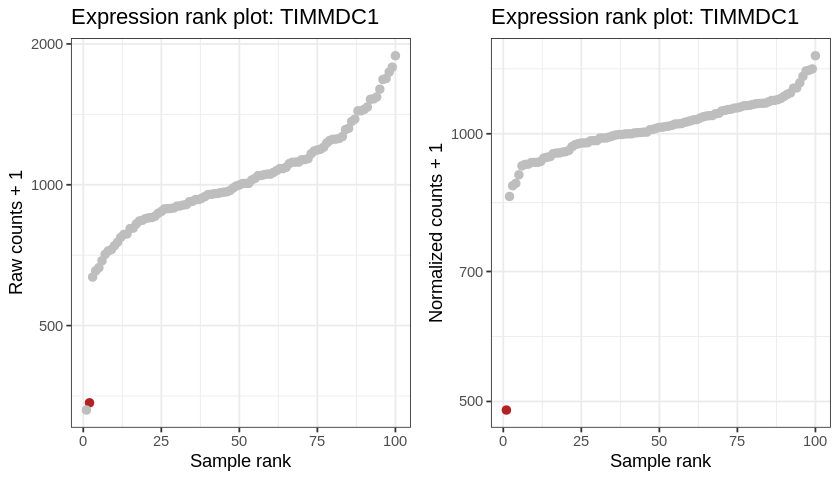

In [ ]:
# make the plot again default size
options(repr.plot.width=7, repr.plot.height=4)

ggarrange(ncol=2,
    plotExpressionRank(ods, "TIMMDC1", norm=FALSE, basePlot=TRUE),
    plotExpressionRank(ods, "TIMMDC1", norm=TRUE,  basePlot=TRUE))

Wondering why the lowest point in the raw uncorrected counts is not significant? It corresponds to the sample with the lowest *sizeFactor*. The autoencoder uses the *sizeFactor* to correct for different library depths across the dataset and hence the point is gone in the normalized plot. 

To make sure the fit was good, we can look at the quantile-quantile plot. 

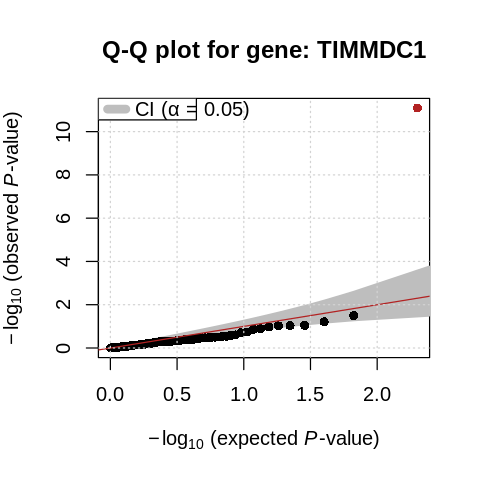

In [ ]:
# set again the default size for the plot
options(repr.plot.width=4, repr.plot.height=4)

plotQQ(ods, "TIMMDC1")

Interested users can also plot the observed vs the expected gene expression levels to investigate the test statistics with the `plotExpectedVsObservedCounts` function.

## What to do if you see many outliers in a case?

Let's have a look at a second case: **NA11918**.

* How many outliers do you see in this case?
* Are they all disease-related?
* How could you prioritize further to get a handful of candidates only?
* Could a Z score cutoff be helpful?

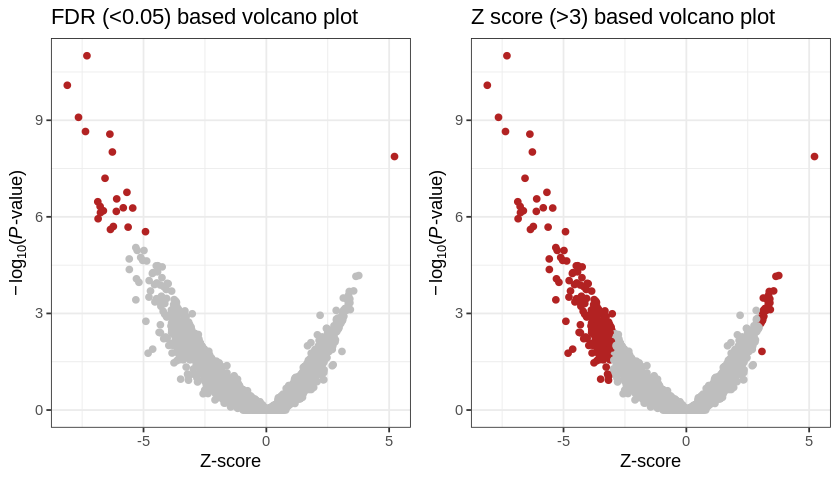

In [ ]:
# make the plot wider
options(repr.plot.width=7, repr.plot.height=4)

# Volcano plot with significance based on p value and on Z score threshold
ggarrange(ncol=2,
    plotVolcano(ods, "NA11918", main="FDR (<0.05) based volcano plot", 
            base=TRUE, padjCutoff=0.05, zScoreCutoff=0),
    plotVolcano(ods, "NA11918", main="Z score (>3) based volcano plot",
            base=TRUE, padjCutoff=1, zScoreCutoff=3))

In [ ]:
# subset results for this patient
res[sampleID == "NA11918"]

geneID,sampleID,pValue,padjust,zScore,l2fc,rawcounts,normcounts,meanCorrected,theta,aberrant,AberrantBySample,AberrantByGene,padj_rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
BRWD3,NA11918,9.912019e-12,1.584084e-06,-7.30,-1.55,276,268.88,791.68,62.89,TRUE,22,1,1.0
PCED1B,NA11918,8.187413e-11,6.542334e-06,-8.10,-6.76,1,1.16,253.15,7.76,TRUE,22,1,2.0
KLHL3,NA11918,8.106887e-10,4.318658e-05,-7.65,-3.55,7,23.63,298.54,19.21,TRUE,22,1,3.0
GOPC,NA11918,2.697668e-09,8.622527e-05,-6.37,-0.82,511,651.26,1143.54,162.43,TRUE,22,1,4.5
PRKD3,NA11918,2.236631e-09,8.622527e-05,-7.36,-4.34,31,46.08,990.91,9.54,TRUE,22,1,4.5
DNMT3A,NA11918,9.679296e-09,2.578152e-04,-6.27,-1.25,276,608.10,1439.17,66.27,TRUE,22,1,6.0
EEF1A1P4,NA11918,1.338870e-08,3.056724e-04,5.22,0.90,3279,3923.37,2122.09,67.63,TRUE,22,1,7.0
GOLGA8A,NA11918,6.331866e-08,1.264905e-03,-6.57,-3.44,124,200.67,2184.00,10.54,TRUE,22,1,8.0
CHD3,NA11918,1.731402e-07,3.074479e-03,-5.68,-1.11,1020,1746.91,3755.65,61.94,TRUE,22,1,9.0


And if you want to have the Z score based results table you can extract it as following:

In [ ]:
resZscore <- results(ods, padjCutoff=1, zScoreCutoff=3)
resZscore[sampleID == "NA11918"]

geneID,sampleID,pValue,padjust,zScore,l2fc,rawcounts,normcounts,meanCorrected,theta,aberrant,AberrantBySample,AberrantByGene,padj_rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
BRWD3,NA11918,9.912019e-12,1.584084e-06,-7.30,-1.55,276,277.29,815.55,62.89,TRUE,271,1,1.0
PCED1B,NA11918,8.187413e-11,6.542334e-06,-8.10,-6.76,1,1.13,243.48,7.76,TRUE,271,2,2.0
KLHL3,NA11918,8.106887e-10,4.318658e-05,-7.65,-3.55,7,24.11,318.92,19.21,TRUE,271,1,3.0
GOPC,NA11918,2.697668e-09,8.622527e-05,-6.37,-0.82,511,661.75,1167.13,162.43,TRUE,271,1,4.5
PRKD3,NA11918,2.236631e-09,8.622527e-05,-7.36,-4.34,31,47.85,1002.16,9.54,TRUE,271,1,4.5
DNMT3A,NA11918,9.679296e-09,2.578152e-04,-6.27,-1.25,276,625.14,1491.90,66.27,TRUE,271,1,6.0
EEF1A1P4,NA11918,1.338870e-08,3.056724e-04,5.22,0.90,3279,3973.77,2127.49,67.63,TRUE,271,1,7.0
GOLGA8A,NA11918,6.331866e-08,1.264905e-03,-6.57,-3.44,124,205.94,2254.99,10.54,TRUE,271,1,8.0
CHD3,NA11918,1.731402e-07,3.074479e-03,-5.68,-1.11,1020,1780.03,3844.86,61.94,TRUE,271,1,9.0


## Expression-Outlier-Exercise for later

If you want to test the knowledge you gained in this tutorial, you can try to solve this case by yourself.

What we know:

`HG00103` has an early-onset rare disease and suffers from 
  * microcephaly
  * brain atrophy
  * reduced activities of mitochondrial respiratory complexes I and III

Can you find the disease causing gene for this case?

In [ ]:

# TODO write your code with some documentation. 
# To get you started some questions below

# * what are the possible candidates
# * what kind of visualization do we have
# * have a detailed look at some of the outliers
# * can we trust the model fit?


Did you find the right candidate? If you want to validate your findings please have a look at this [paper](https://www.ncbi.nlm.nih.gov/pubmed/26626369).

# Aberrant Splicing Detection in RNA-seq data

A short introduction to splicing can be found [here](https://docs.google.com/presentation/d/1a7KZ6FXwVmGqF-FMAnz0QTk07WgzRWAbFhSNrUBspIQ/edit?pli=1#slide=id.g64b01c344e_4_394).

## Data import
---

First, we have to load the [*FRASER*](http://github.com/c-mertes/FRASER) package that we will use to run the full aberrant splicing analysis. For efficient data handling and visualization we further load [*data.table*](https://cran.r-project.org/web/packages/data.table/index.html), [*ggplot2*](https://cran.r-project.org/web/packages/ggplot2/index.html), and [*ggpubr*](https://cran.r-project.org/web/packages/ggpubr/index.html).

In [ ]:
library(FRASER)
library(data.table)
library(ggplot2)
library(ggpubr)

We will use the following [dataset](https://i12g-gagneurweb.in.tum.de/public/workshops/RNAseq_ASHG19/input_data/splicing), which is already available in this session.

Due to time reasons, we will go through the standard analysis workflow only with a toy dataset. In the end, we provide a fully preprocessed and fitted model to do the final prioritization.

We assume that the split reads (reads spanning an exon-exon junction) and non-split reads (reads spanning a splice site) are already counted (e.g. with [FraseR](https://github.com/c-mertes/FraseR), [HTSeq](https://htseq.readthedocs.io/en/release_0.11.1/count.html) or [RSubread](https://bioconductor.org/packages/release/bioc/html/Rsubread.html)).

Let's prepare and load the data needed for the aberrant splicing analysis.
* Counts (split reads + non-split reads)
* Sample annotation

In [ ]:
# load and prepare annotation (add needed columns for FRASER)
anno <- fread("annotation.tsv")[,1:6]
anno[, sampleID:=INDIVIDUAL]
anno[, bamFile:="<path/to/bam/file/for/each/sample.bam>"]

# get raw counts (remove first column since it is the row index)
junctionCts   <- fread("./splicing/raw_junction_counts.tsv.gz")
spliceSiteCts <- fread("./splicing/raw_site_counts.tsv.gz")

Let's have a look at the count matrix and what extra information we have.

In [ ]:
head(anno)
junctionCts[1:6,1:15]
spliceSiteCts[1:6,1:15]

RNA_ID,SEX,ORIGIN,LAB,INDIVIDUAL,phase1TG,sampleID,bamFile
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
HG00096.1.M_111124_6,male,British,UNIGE,HG00096,1,HG00096,<path/to/bam/file/for/each/sample.bam>
HG00103.4.M_120208_3,male,British,ICMB,HG00103,1,HG00103,<path/to/bam/file/for/each/sample.bam>
HG00106.4.M_120208_5,female,British,ICMB,HG00106,1,HG00106,<path/to/bam/file/for/each/sample.bam>
HG00111.2.M_111215_4,female,British,CNAG_CRG,HG00111,1,HG00111,<path/to/bam/file/for/each/sample.bam>
HG00116.2.M_120131_1,male,British,CNAG_CRG,HG00116,1,HG00116,<path/to/bam/file/for/each/sample.bam>
HG00126.1.M_111124_8,male,British,UNIGE,HG00126,1,HG00126,<path/to/bam/file/for/each/sample.bam>


seqnames,start,end,width,strand,startID,endID,HG00096,HG00103,HG00106,HG00111,HG00116,HG00126,HG00132,HG00149
<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,12228,12594,367,+,1,686279,0,0,0,0,0,0,0,1
chr1,12722,13224,503,+,2,686280,0,0,0,0,0,0,0,0
chr1,13053,13220,168,+,3,686281,0,0,0,0,0,0,0,0
chr1,14598,1378195,1363598,-,4,686282,0,0,0,0,0,0,0,0
chr1,14708,14708,1,+,5,686283,0,0,0,0,0,0,0,0
chr1,14738,14969,232,-,6,686284,0,0,0,1,0,0,0,0


seqnames,start,end,width,strand,spliceSiteID,type,HG00096,HG00103,HG00106,HG00111,HG00116,HG00126,HG00132,HG00149
<chr>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,12227,12228,2,*,1,Donor,0,0,0,0,0,0,0,0
chr1,12594,12595,2,*,685990,Acceptor,0,0,0,0,0,0,0,0
chr1,12721,12722,2,*,2,Donor,0,0,0,0,0,0,0,0
chr1,13052,13053,2,*,3,Donor,0,0,0,1,0,0,0,1
chr1,13220,13221,2,*,685992,Acceptor,3,0,0,0,0,0,0,0
chr1,13224,13225,2,*,685991,Acceptor,3,0,0,0,0,0,0,0


Now we can put all the data together and create a FRASER dataset object.

In [ ]:
# create FRASER object
fds <- FraserDataSet(colData=anno, junctions=junctionCts, 
        spliceSites=spliceSiteCts)
fds

Wed Jun 24 16:46:51 2020: The given working directory '/tmp/RtmpsE3ajd/FRASER' does not exists. We will create it.



-------------------- Sample data table -----------------
# A tibble: 100 x 8
   RNA_ID      SEX    ORIGIN LAB   INDIVIDUAL phase1TG sampleID bamFile         
   <chr>       <chr>  <chr>  <chr> <chr>         <int> <chr>    <chr>           
 1 HG00096.1.… male   Briti… UNIGE HG00096           1 HG00096  <path/to/bam/fi…
 2 HG00103.4.… male   Briti… ICMB  HG00103           1 HG00103  <path/to/bam/fi…
 3 HG00106.4.… female Briti… ICMB  HG00106           1 HG00106  <path/to/bam/fi…
 4 HG00111.2.… female Briti… CNAG… HG00111           1 HG00111  <path/to/bam/fi…
 5 HG00116.2.… male   Briti… CNAG… HG00116           1 HG00116  <path/to/bam/fi…
 6 HG00126.1.… male   Briti… UNIGE HG00126           1 HG00126  <path/to/bam/fi…
 7 HG00132.2.… female Briti… CNAG… HG00132           0 HG00132  <path/to/bam/fi…
 8 HG00149.1.… male   Briti… UNIGE HG00149           1 HG00149  <path/to/bam/fi…
 9 HG00150.4.… female Briti… ICMB  HG00150           1 HG00150  <path/to/bam/fi…
10 HG00176.4.… female Finni… ICM

We will only use a subset to run a fast analysis. Let's take only 2 chromosomes and 50 samples. Also to speed up the processing, we keep the full data in memory and not on disk using HDF5. 

In [ ]:
fds <- fds[seqnames(fds) %in% c("chr3", "chr19"), 1:50]
dontWriteHDF5(fds) <- TRUE
fds

-------------------- Sample data table -----------------
# A tibble: 50 x 8
   RNA_ID      SEX    ORIGIN LAB   INDIVIDUAL phase1TG sampleID bamFile         
   <chr>       <chr>  <chr>  <chr> <chr>         <int> <chr>    <chr>           
 1 HG00096.1.… male   Briti… UNIGE HG00096           1 HG00096  <path/to/bam/fi…
 2 HG00103.4.… male   Briti… ICMB  HG00103           1 HG00103  <path/to/bam/fi…
 3 HG00106.4.… female Briti… ICMB  HG00106           1 HG00106  <path/to/bam/fi…
 4 HG00111.2.… female Briti… CNAG… HG00111           1 HG00111  <path/to/bam/fi…
 5 HG00116.2.… male   Briti… CNAG… HG00116           1 HG00116  <path/to/bam/fi…
 6 HG00126.1.… male   Briti… UNIGE HG00126           1 HG00126  <path/to/bam/fi…
 7 HG00132.2.… female Briti… CNAG… HG00132           0 HG00132  <path/to/bam/fi…
 8 HG00149.1.… male   Briti… UNIGE HG00149           1 HG00149  <path/to/bam/fi…
 9 HG00150.4.… female Briti… ICMB  HG00150           1 HG00150  <path/to/bam/fi…
10 HG00176.4.… female Finni… ICMB

## Data preprocessing and QC

As with gene expression analysis, a good quality control of the raw data is crucial. For some hints please refere to the [gene expression slides](https://docs.google.com/presentation/d/1a7KZ6FXwVmGqF-FMAnz0QTk07WgzRWAbFhSNrUBspIQ/edit?pli=1#slide=id.g64b01c344e_4_51).

### Filtering the data

Before we can filter the data, we have to compute the main splicing metric: the $\psi$-value (Percent Spliced In).

In [ ]:
fds <- calculatePSIValues(fds)

Wed Jun 24 16:46:54 2020: Calculate the PSI 5 and 3 values ...

Wed Jun 24 16:47:18 2020: Calculate the PSI site values ...

Wed Jun 24 16:47:42 2020: Writing final FRASER object ('/tmp/RtmpsE3ajd/FRASER/savedObjects/Data_Analysis/fds-object.RDS').

Wed Jun 24 16:47:56 2020: Calculate the delta for psi5 values ...

Wed Jun 24 16:47:56 2020: Calculate the delta for psi3 values ...

Wed Jun 24 16:47:57 2020: Calculate the delta for psiSite values ...

Wed Jun 24 16:47:58 2020: Writing final FRASER object ('/tmp/RtmpsE3ajd/FRASER/savedObjects/Data_Analysis/fds-object.RDS').




Now we can have some cut-offs to filter down the number of junctions we want to test later on.

Currently, we keep only junctions which support the following:
* At least one sample has 20 reads
* 5% of the samples have at least 1 read

Furthemore one could filter for:
* At least one sample has a $|\Delta\psi|$ of 0.1

In [ ]:
# TODO make filterExpression working together with OUTRIDER
fds <- filterExpressionAndVariability(fds, minDeltaPsi=0.0, filter=FALSE)

Wed Jun 24 16:49:52 2020: Filtering out introns with low read support ...

Wed Jun 24 16:49:57 2020: Filtering out non-variable introns ...

Wed Jun 24 16:49:58 2020: Filtering done!



Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 60 rows containing missing values (geom_bar).”


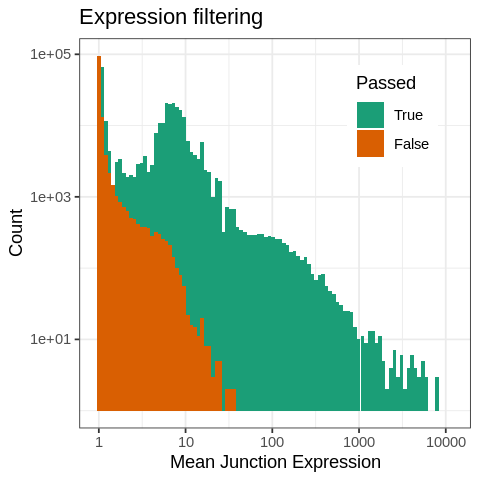

In [ ]:
# make the plot wider
options(repr.plot.width=4, repr.plot.height=4)

plotFilterExpression(fds, bins=100)

After looking at the expression distribution between filtered and unfiltered junctions, we can now subset the dataset.

In [ ]:
fds <- fds[mcols(fds, type="j")[,"passed"],]
fds

-------------------- Sample data table -----------------
# A tibble: 50 x 8
   RNA_ID      SEX    ORIGIN LAB   INDIVIDUAL phase1TG sampleID bamFile         
   <chr>       <chr>  <chr>  <chr> <chr>         <int> <chr>    <chr>           
 1 HG00096.1.… male   Briti… UNIGE HG00096           1 HG00096  <path/to/bam/fi…
 2 HG00103.4.… male   Briti… ICMB  HG00103           1 HG00103  <path/to/bam/fi…
 3 HG00106.4.… female Briti… ICMB  HG00106           1 HG00106  <path/to/bam/fi…
 4 HG00111.2.… female Briti… CNAG… HG00111           1 HG00111  <path/to/bam/fi…
 5 HG00116.2.… male   Briti… CNAG… HG00116           1 HG00116  <path/to/bam/fi…
 6 HG00126.1.… male   Briti… UNIGE HG00126           1 HG00126  <path/to/bam/fi…
 7 HG00132.2.… female Briti… CNAG… HG00132           0 HG00132  <path/to/bam/fi…
 8 HG00149.1.… male   Briti… UNIGE HG00149           1 HG00149  <path/to/bam/fi…
 9 HG00150.4.… female Briti… ICMB  HG00150           1 HG00150  <path/to/bam/fi…
10 HG00176.4.… female Finni… ICMB

### Sample co-variation

Since $\psi$ values are ratios within a sample, one might think that there should not be as much correlation structure as observed in gene expression data within the splicing data.

This is not true as we do see strong sample co-variation across different tissues and cohorts. Let's have a look into our data to see if we do have correlation structure or not. To have a better estimate, we use the logit transformed $\psi$ values to compute the correlation. 

In [ ]:
# Make heatmap figure bigger
options(repr.plot.width=6, repr.plot.height=5)

plotCountCorHeatmap(fds, type="psi5", logit=TRUE)

ERROR: ignored

## Detection of aberrant splicing events

After preprocessing the raw data and visualizing it, we can start our analysis. Let's start with the first step in the aberrant splicing detection: the model fitting.


### Fitting the splicing model

During the fitting procedure, we will normalize the data and correct for confounding effects by using a denoising autoencoder.  Here we use a predefined latent space with a dimension $q=10$. Using the correct dimension is crucial to have the best performance. Alternatively, one can also use a PCA to correct the data.

In [ ]:
fds <- FRASER(fds, q=10,
        correction="PCA", # we use the PCA approach here to speed up the tutorial
        BPPARAM=MulticoreParam(4, progressbar=TRUE)) # Should take around 3 min

Let's see how well the correction worked by looking at the correlation heatmap again.

In [ ]:
plotCountCorHeatmap(fds, type="psi5", normalized=TRUE, logit=TRUE)

### Calling splicing outliers

Again, before we extract the results let's add the interpretable HGNC symbols. *FRASER* comes already with an annotation function. The function uses **biomaRt** in the background to overlap the genomic ranges with the known HGNC symbols. 

Here we assume a beta binomial distribution and call outliers based on the significance level. But again the user can choose between a p value cutoff, a Z score cutoff or both. 


In [ ]:
# annotate
# fds <- annotateRanges(fds)

# retrive results
res <- results(fds)
res

## Finding splicing candidates in a patient

We worked already with the following patient: **NA11918**, in whom we found downregulation of **TIMMDC1**.

Let's see if we also got some splicing candidates for the same sample.

In [ ]:
# Make the plotting area smaller again
options(repr.plot.width=4, repr.plot.height=4)

plotVolcano(fds, type="psi5", "NA11918")

Which are the splicing events in detail? Do they fit with our previous candidate? 

In [ ]:
res[res$sampleID == "NA11918"]

Since we do detect the same gene again, let's have a look at the junction level.

In [ ]:
plotExpression(fds, type="psi5", result=res[2])

That we do find the same gene through two different approaches increases the confidence in the event. Further, it gives clues on the mechanism of the event (eg. NMD through alternative isoforms). But further investigations of causal variants are needed.

# Mono Allelic Expression

For a short introduction to MAE please refer to the [slides](https://docs.google.com/presentation/d/1a7KZ6FXwVmGqF-FMAnz0QTk07WgzRWAbFhSNrUBspIQ/edit?pli=1#slide=id.g64b01c344e_4_388).

## Load the allelic counts
---

For the MAE analysis we will use the *tMAE* package.


In [ ]:
library(ggplot2)
library(data.table)
library(tMAE)

Now we can load the allelic counts. For this tutorial we only use 2 samples and a subset of the variants. 


In [ ]:
# allelic counts generated using ASEReadCounter
allelicCountsFile <- 'https://i12g-gagneurweb.in.tum.de/public/workshops/RNAseq_ASHG19/input_data/mae/allelic_counts.tsv.gz'
allelicCounts <- fread(allelicCountsFile)

# print data
allelicCounts[1:4,]
dim(allelicCounts)

Check the existing samples in the table.

In [ ]:
print('IDs in table')
unique(allelicCounts$MAE_ID)

Plot counts of alternative vs reference allele. Which ones would you say are mono-allelically expressed?

In [ ]:
ggplot(allelicCounts, aes(refCount+1, altCount+1)) + geom_point() +
    geom_abline(slope=1, intercept=0) + 
    scale_y_log10() + scale_x_log10() + theme_bw()


## Run MAE test
---
Now we are ready to run the negative binomial test using the `DESeq4MAE` function from the *tMAE* package

In [ ]:
resMAE <- DESeq4MAE(allelicCounts, minCoverage = 10)
head(resMAE)

### Determine the number of mono-allelic events

We define a variant to be mono-allelically expressed if its p-adjusted < 0.05. Determine how many mono-allelic events there are per sample.




In [ ]:
# Add significant column
resMAE[, signif := padj < 0.05]

# Get number of cases
print('MAE significant variants')
resMAE[signif == TRUE, .N, by = MAE_ID]

In the rare disease setting, variants that are mono-allelically expressed for the altervative are more interesting. We define them as having a ratio of the alternative $\ge 0.8$ and an $FDR < 0.05$. 

Determine how many mono-allelic events for the **alternative** allele there are per sample.

In [ ]:
# Add column for significant mono-allelic expression of the alternative
resMAE[, signif_ALT := signif == TRUE & altRatio >= 0.8]

# Get number of cases
print('MAE for the alternative significant variants')
resMAE[signif_ALT == TRUE, .N, by = MAE_ID]

## Find rare variants and integrate them to results
---
Add minor allele frequencies from [gnomAD](https://gnomad.broadinstitute.org/). The following code snippet requires the gnomAD libraries to be downloaded which are ~5GB each as they contain the minor allele frequencies of the whole genome. Therefore, we will not execute it here, but simply read the results object with annotated allele frequencies.

In [ ]:
## If your data is based on assembly hg37
# library(MafDb.gnomAD.r2.1.hs37d5)
# mafdb <- MafDb.gnomAD.r2.1.hs37d5

## If your data is based on assembly hg38
# library(MafDb.gnomAD.r2.1.GRCh38)
# mafdb <- MafDb.gnomAD.r2.1.GRCh38

## convert results table into GRanges object
# rng <- GRanges(seqnames = data$contig, 
#               ranges = IRanges(start = data$position, end = data$position), 
#               strand = '*')
# resMAE$gnomadAF <- gscores(mafdb, rng)$AF


Read the annotated results. How many rare variants are there?

In [ ]:
# Merge results with annotation object
resAnnot <- fread('https://i12g-gagneurweb.in.tum.de/public/workshops/RNAseq_ASHG19/input_data/mae/mae_annotated_results.tsv.gz')

resAnnot[, rare := (gnomadAF <= 0.01 | is.na(gnomadAF))]
print('Number of rare events in total (including non significant variants)')
resAnnot[rare == TRUE, .N]


Which are the rare mono-allelic events of these 2 samples?

In [ ]:
resAnnot[signif_ALT == TRUE & rare == TRUE]

Visualize them using the `plotAllelicCounts` function from the tMAE pkg

In [ ]:
sample1 <- 'HG00106'
plotAllelicCounts(resAnnot[MAE_ID == sample1], 
        rare_column = 'rare', title = sample1) +
    theme(legend.position="bottom")


In [ ]:
sample2 <- 'HG00111'
plotAllelicCounts(resAnnot[MAE_ID == sample2], 
        rare_column = 'rare', title = sample2) + 
    theme(legend.position="bottom")

After running the test and adding minor allele frequencies for all the 100 samples in the data set, we obtained the following results for each filter:

<img src="https://github.com/c-mertes/RNAseq-ASHG19/raw/master/src/cascade_plot.png" alt="no image" width="400"/>

For further validation, obtain gene and type of variant from the annotated VCF file (more info on next section).

# Gene prioritization


**It is not uncommon to have more than one candidate outlier gene when looking at expression, splicing or allele specific events. It is useful to kown that there are ways to prioritize those genes.
Here we will see how coming back to phenotype and genotype data can help reduce the list of candidates in a case informed way.** 

Because of time constraint, we will focus on an example with genes obtained from expression outliers. In real life, you can apply the same strategy to other types of candidates, such as splicing or ASE outliers. 




## Set up working session
---

First a few packages need to be loaded. \\
(1) [VariantAnnotation](https://bioconductor.org/packages/release/bioc/html/VariantAnnotation.html): annotate variants, compute amino acid coding changes, predict coding outcomes. \\
(2) [TVTB](https://bioconductor.org/packages/release/bioc/html/TVTB.html) (The VCF ToolBox): filter, summarise and visualise genetic variation data stored in VCF files. \\
(3) [annotables](https://github.com/stephenturner/annotables): annotating/converting Gene IDs. \\
(4) [tidyverse](https://www.tidyverse.org/): collection of packages designed for data science \\
(5) [data.table](https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html): data manipulation operations 

In [ ]:
library(VariantAnnotation)
library(TVTB)
library(annotables)
library(ensemblVEP)
library(tidyverse)
library(data.table)



## Case 1
This boy was the third child of healthy non-consanguineous French parents. Pregnancy and delivery were uneventful. Early psychomotor development was normal. However, speech development was delayed, acquiring language at the age of 4. At 11, he began to experience psychomotor regression and progressive visual loss. At current (by the time of the publication) age of 47, he has severe walking difficulties, blindness, abnormal behaviour (easily frightened, sometimes aggressive) and spontaneous speech.

In our dataset, this sample is named **NA11918**

### Get list of candidate genes from OUTRIDER
Here we download the list of outlier gene that you generated using OUTRIDER in an earlier session.

In [ ]:
# Download list of candidates
results_link="https://i12g-gagneurweb.in.tum.de/public/workshops/RNAseq_ASHG19/input_data/outrider/results_pvalue.tsv.gz"
outrider_results_genes=fread(results_link)

# Filter for the case of interest
outrider_results_genes=outrider_results_genes %>%
        filter(sampleID=="NA11918") %>%
        select(geneID) %>%
        unlist

# Take a look at what the genes list look like
head(outrider_results_genes)

# Get the number of candidate genes for that case
print("The total number of candidate genes within this case:")
length(outrider_results_genes)


You can see that the gene names are not totally in an Ensembl format. The number you see correspond to a version of the annotation.
The gene names need to be reformated so that we keep only the official gene name in our analyses.


We also see that we have 22 candidate genes.

In [ ]:
# Modify gene format
outrider_results_genes=str_extract(outrider_results_genes, "ENSG[0-9]+")


# Look at the changes
head(outrider_results_genes)


Now the gene name correspond to the official Ensembl symbols. It is possible to get a bit more information on those. 
In particular we can easily obtain their symbol and description using the package ` annotable `.


In [ ]:
# Query annotable Grch37 object and keep only genes that are in the list of outliers
candidate_genes=grch37 %>% filter(ensgene %in% outrider_results_genes)

# Look at the results
head(candidate_genes)

We now have the list of candidate genes and a bit more information on what they are. We are ready to filter this list to keep only the genes that are linked to the symptoms of the case of interest.

In our case, symptoms are:
* Developmental regression ([HP:0002376](https://hpo.jax.org/app/browse/term/HP:0002376))
* Ataxia([HP:0001251](https://hpo.jax.org/app/browse/term/HP:0001251))
* Ophthalmoplegia ([HP:0000602](https://hpo.jax.org/app/browse/term/HP:0000602))
* Visual impairment ([HP:0000505](https://hpo.jax.org/app/browse/term/HP:0000505))


As you can see, there is an ID beside each symptom. Those are HPO term IDs, as found in the Human Phenotype Ontology [database](https://hpo.jax.org/app/).


### Annotate candidate genes with HPO terms
#### Read in sample phenotype metadata


In [ ]:
# We define the list of HPO terms for the case
sample_HPO=c("HP:0002376","HP:0001251", "HP:0000602","HP:0000505")

sample_HPO

#### Load gene to HPO ID file from HPO database 
The Human Phenotype Ontology gives access to a very useful file, showing the link between symptoms and genes. This file is updated regularly so we recommend to **download the latest version** whenever possible.

You can download this file [here](http://compbio.charite.de/jenkins/job/hpo.annotations.monthly/lastStableBuild/artifact/annotation/ALL_SOURCES_FREQUENT_FEATURES_phenotype_to_genes.txt)

In [ ]:

# Get the file URL
hpo_annotations_url ="http://compbio.charite.de/jenkins/job/hpo.annotations.monthly/lastStableBuild/artifact/annotation/ALL_SOURCES_FREQUENT_FEATURES_phenotype_to_genes.txt"

# Read the file
gene_hpo <-fread(hpo_annotations_url, skip=1)

# Select only the columns of interest (Gene and HPO term)
gene_hpo <- gene_hpo[, c(4, 1)]
colnames(gene_hpo) <- c("Gene", "Term")

# Look at the results
head(gene_hpo)

#### Get subset of genes that could match symptoms list
Now that we have downloaded that file, we want to keep only the genes that are phenotypically relevant to the case.

1. Filter for HPO terms corresponding to the case
2. Obtain the Ensembl IDs for the genes that are associated to those HPO terms


In [ ]:
# Get list of genes corresponding to the case symptoms.
genes_hpo_case=gene_hpo %>% 
        filter(Term %in% sample_HPO) %>% 
        left_join(grch37,by=c("Gene"="symbol"))
genes_hpo_case=genes_hpo_case %>% 
        select(ensgene) %>% 
        unique %>% 
        unlist
head(genes_hpo_case)

`genes_hpo_case` contains the Ensembl IDs of genes associated with HPO terms for the case.

You can quicly check how many genes are currently linked with the symptoms of your case of interest.

In [ ]:
# Get number of genes linked to case symptoms
length(genes_hpo_case)

There are 1,519 genes that could match some of the patient's symtoms.



---



#### Subset the list of genes to outlier candidates 
Here the assumption is that if there is an expression perturbation on the causal gene, this gene is somehow linked to some of the symtoms of the patient.\
So we want to **filter** the list of genes somehow linked to the patients symptoms (listed in `genes_hpo_case`) for the one obtained as candidates in previous work.


In [ ]:
# Filter outlier genes for genes linked to the phenotype.
candidate_genes.hpo=candidate_genes %>% filter(ensgene %in% genes_hpo_case)

# Get the number of genes left
cat("The number of outlier genes left after filtering associated with the disease:")
length(candidate_genes.hpo$ensgene)

# Take a look at the results
candidate_genes.hpo

As you can see the list of potential genes is now much reduced. We dropped from 22 candidates to 2 genes, [*MCOLN1*](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MCOLN1) and [*DNMT3A*](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DNMT3A).


---

---

### Annotate with variant information

We can go further and annotate our candidate with the variant information for the case.

To do so, we need to transform the candidate gene list into the right format so that we can use the genes when reading in the [VCF](https://www.internationalgenome.org/wiki/Analysis/Variant%20Call%20Format/vcf-variant-call-format-version-40/) file in R.

#### Build a GRanges object with list of genes obtain in previous steps
We are using R packages that have been developped to handle and filter VCF files. 
Here we want to upload only the part of the VCF file that is in regions of interest (ie our candidate genes). We can do this by giving as an input an object of type [GRange](https://web.mit.edu/~r/current/arch/i386_linux26/lib/R/library/GenomicRanges/html/GRanges-class.html).


The next steps are transforming our list of candidate genes to the right format so that we can proceed with the analysis.

1. Change start and end position to include potential regulatory regions (+/- 1kb here).
note that you can customize this distance or use the gene coordinates only.


In [ ]:
# Extending the start/end coordinates to 1kb around the gene of interest 
candidate_genes=candidate_genes.hpo %>% 
        mutate(new_start=pmin(start,end)-1e3, new_end=pmax(start,end)+1e3)

# Take a look at the results
head(candidate_genes)

2. Transform data frame into GRange object

In [ ]:
# Create a GRange Object
candidate_genes.gr=makeGRangesFromDataFrame(
        candidate_genes, ignore.strand=TRUE,
        start.field="new_start",end.field="new_end")

# Add gene names in GRanges object
names(candidate_genes.gr)=candidate_genes$ensgene

candidate_genes.gr

#### Load the vcf file
Now that we have the coordinates of the candidate genes in the right format, we can process the VCF file.

For the purpose of this workshop, the VCF file needs to be annotate with [Variant Effect Predictor](https://uswest.ensembl.org/info/docs/tools/vep/index.html) (VEP), which determines the effect of the variants on genes, transcripts, etc ...

Here, we take a subset of the thousand genomes VCF in which we have injected variants of interest.


In [ ]:
# VEP annotated VCF file
vcfFile <- "./variants/1000G_subset_exome.vep.vcf.gz"

# index the VCF file
indexVcf(vcfFile)

# create a reference 
vcfFile <- TabixFile(vcfFile)
vcfFile


#### Read in VCF file for sample of interest
Here only the sample of interest and variants overlapping the genes of interest will be looked at.


In [ ]:
# Create parameter file to read only the data for the case and around candidate genes
params=ScanVcfParam(samples="NA11918", which=candidate_genes.gr)

# Read in VCF file filtering data using the parameter file we just created
vcf_rng <- readVcf(vcfFile, "hg19", params)
head(rowRanges(vcf_rng), 3)

#### Filter for Heterozygous or Homozygous Alt and genes of interest
In our situation, the VCF contains genotypes for sites that are homozygous for the reference allele. As we are not interested in those we filter them out.
We also make sure that we are looking only at the variants that are annotated for the genes of interest and not genes nearby.

In [ ]:
candidate_genes

In [ ]:
# Create a filter on variants het or homozygous alt
Hetfilt <- FilterRules(list(HetorHomAlt = 
        function(x) geno(x)$GT %in% c("0|1", "1|1", "1|0")))

# Create a filter to keep only candidate gene annotations
GeneFilt<-VcfVepRules(exprs = list(Cand_genes = 
        bquote(SYMBOL %in% .(candidate_genes$symbol) )))                            

# Combine those filters
combinedPreFilters <- VcfFilterRules(
    Hetfilt, 
    GeneFilt)
                            
# Apply them on the vcf
vcf_het_cand <- subsetByFilter(vcf_rng, combinedPreFilters)

rowRanges(vcf_het_cand)

#### Get consequence field
In order to see the potential features we can filter on, let's take a look at the consequence field of the VCF

In [ ]:
# Parse the consequence field of the VCF
csq <- parseCSQToGRanges(x=vcf_het_cand, VCFRowID=rownames(vcf_het_cand))
csq[, c("Consequence", "SYMBOL", "BIOTYPE", "gnomAD_AF", "CADD_PHRED")]



#### Define a set of filters

We can create a set of filters that we want to apply on our data, such as distance to transcription start site, allele frequency, [CADD score](https://cadd.gs.washington.edu/), [VEP consequences](https://uswest.ensembl.org/info/genome/variation/prediction/predicted_data.html), etc ... You can customize this and add as many filters as you want.

In [ ]:

# Filter on distance to the gene
vepDistFilter <- VcfVepRules(exprs=list(Distance=expression(DISTANCE <= 1000)))

# Filter on allele frequency
# Here we allow NAs because some variants are uniq to the individual and hence
# not listed in any public database (eg. gnomAD)
vepMAFFilter<- VcfVepRules(exprs = list(MAF = 
        expression(as.numeric(gnomAD_AF) <= 0.01 || gnomAD_AF == "NA")))

# Filter on CADD score
vepCADDFilter <- VcfVepRules(exprs = list(CADD=expression(CADD_PHRED >= 20)))

# Filter on consequences
highImpactVariant<-VcfVepRules(exprs=list(BigImpact=
        expression(grepl(x=Consequence, pattern=paste(collapse="|", c(
                "splice_acceptor_variant", "splice_donor_variant", 
                "stop_gained", "stop_lost","frameshift_variant"))))))

regulatoryVariant<-VcfVepRules(exprs=list(RegVar=
        expression(grepl(x=Consequence, pattern=paste(collapse="|", c(
                "5_prime_UTR_variant", "3_prime_UTR_variant", "intron_variant",
                "NMD_transcript_variant", "upstream_gene_variant", 
                "downstream_gene_variant"))))))

combinedFilters <- VcfFilterRules(
  vepDistFilter,
  vepMAFFilter,
  vepCADDFilter, 
  highImpactVariant,
  regulatoryVariant)

You can play and add or remove filters

In [ ]:
# Look at active filters
active(combinedFilters)

Here we are gonna focus only on **rare** variants

In [ ]:
active(combinedFilters)["BigImpact"] <- FALSE
active(combinedFilters)["RegVar"] <- FALSE
active(combinedFilters)["Distance"] <- FALSE
active(combinedFilters)["CADD"] <- FALSE

active(combinedFilters)["MAF"] <- TRUE

active(combinedFilters)

#### Apply set of filters

In [ ]:
# subset VCF with active filters
vcf_filt <- subsetByFilter(vcf_het_cand, combinedFilters)

csq_filt <- ensemblVEP::parseCSQToGRanges(x = vcf_filt)

unique(csq_filt[,c("Consequence", "SYMBOL", "BIOTYPE", "gnomAD_AF","CADD_PHRED")])

There are only two rare variants in our example. They are both in the same gene, *MCOLN1* which was previously involved in a [disorder](https://www.omim.org/entry/252650#title) linked to ophthalmologic abnormalities, difficulty to speak, slow development. This gene looks like a very good candidate for our case. The presence of those two mutations, one leading to intron retention and the other one leading to a stop codon are good candidates.



In order to see how many variants are left after each filter you can do the following command. Please note that filters that are not active will have no effect on the initial number of variants.



In [ ]:
# Look at number of variants left for each set of filters
summary(evalSeparately(expr=combinedFilters, envir=vcf_het_cand))




---



---



## Playground Case 2
You can try to prioritize other genes by looking at this case **HG00132**.


~12 yo Hispanic female with global developmental delay after normal development until age 18 months, then loss of milestones, head control, and speech; tremors at 21 months; and seizures at 22 months.  Occasional myoclonus, not correlative to EEG.  Gastrostomy fed.  Scoliosis. Brother similiarly affected.


The HPO terms for this case are: HP:0001250,HP:0001298,HP:0002015,HP:0002650,HP:0001263,HP:0002376,HP:0002421,HP:0002371,HP:0001337,HP:0001336,HP:0001260,HP:0003676

The results file for splicing outliers is [here](https://i12g-gagneurweb.in.tum.de/public/workshops/RNAseq_ASHG19/input_data/splicing/results_pvalue.tsv.gz)


The vcf containg variant infromation for HG00132 is [here](https://i12g-gagneurweb.in.tum.de/public/workshops/RNAseq_ASHG19/input_data/variants/1000G_subset_exome.vep.vcf.gz)


This case was solved in this [paper](https://www.nature.com/articles/s41591-019-0457-8)